In [1]:
from __future__ import division 
import sys
import numpy as np
import pickle
import pandas as pd

from scipy.spatial import distance
from scipy.stats import entropy
from scipy.stats import scoreatpercentile 

import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams.update({'font.size': 9})

In [3]:
nature_sheet = pd.read_excel('data/LibraryNatural.xls')
#design_sheet = pd.read_excel('data/LibraryDesign.xls')
design_sheet = pd.read_excel('data/20220928_design_sheet.xlsx')

nature_sheet = nature_sheet[nature_sheet['In Training Set']==1]
nature_sheet = nature_sheet.drop_duplicates(subset='Sequence_aligned')
RE_corr = nature_sheet['RE_norm']# natural

In [4]:
designed_seq = design_sheet.seq.tolist()
#designed_seq = [i[:16]+i[18:44]+i[45:] for i in designed_seq]
res = design_sheet['RE_norm'].copy()
print(np.count_nonzero(np.isnan(res)))

filter1 = design_sheet['count_t0_ex1']<5
filter2 = design_sheet['count_t0_ex2']<5

res[filter1|filter2] = np.nan
print(np.count_nonzero(np.isnan(res)))

563
589


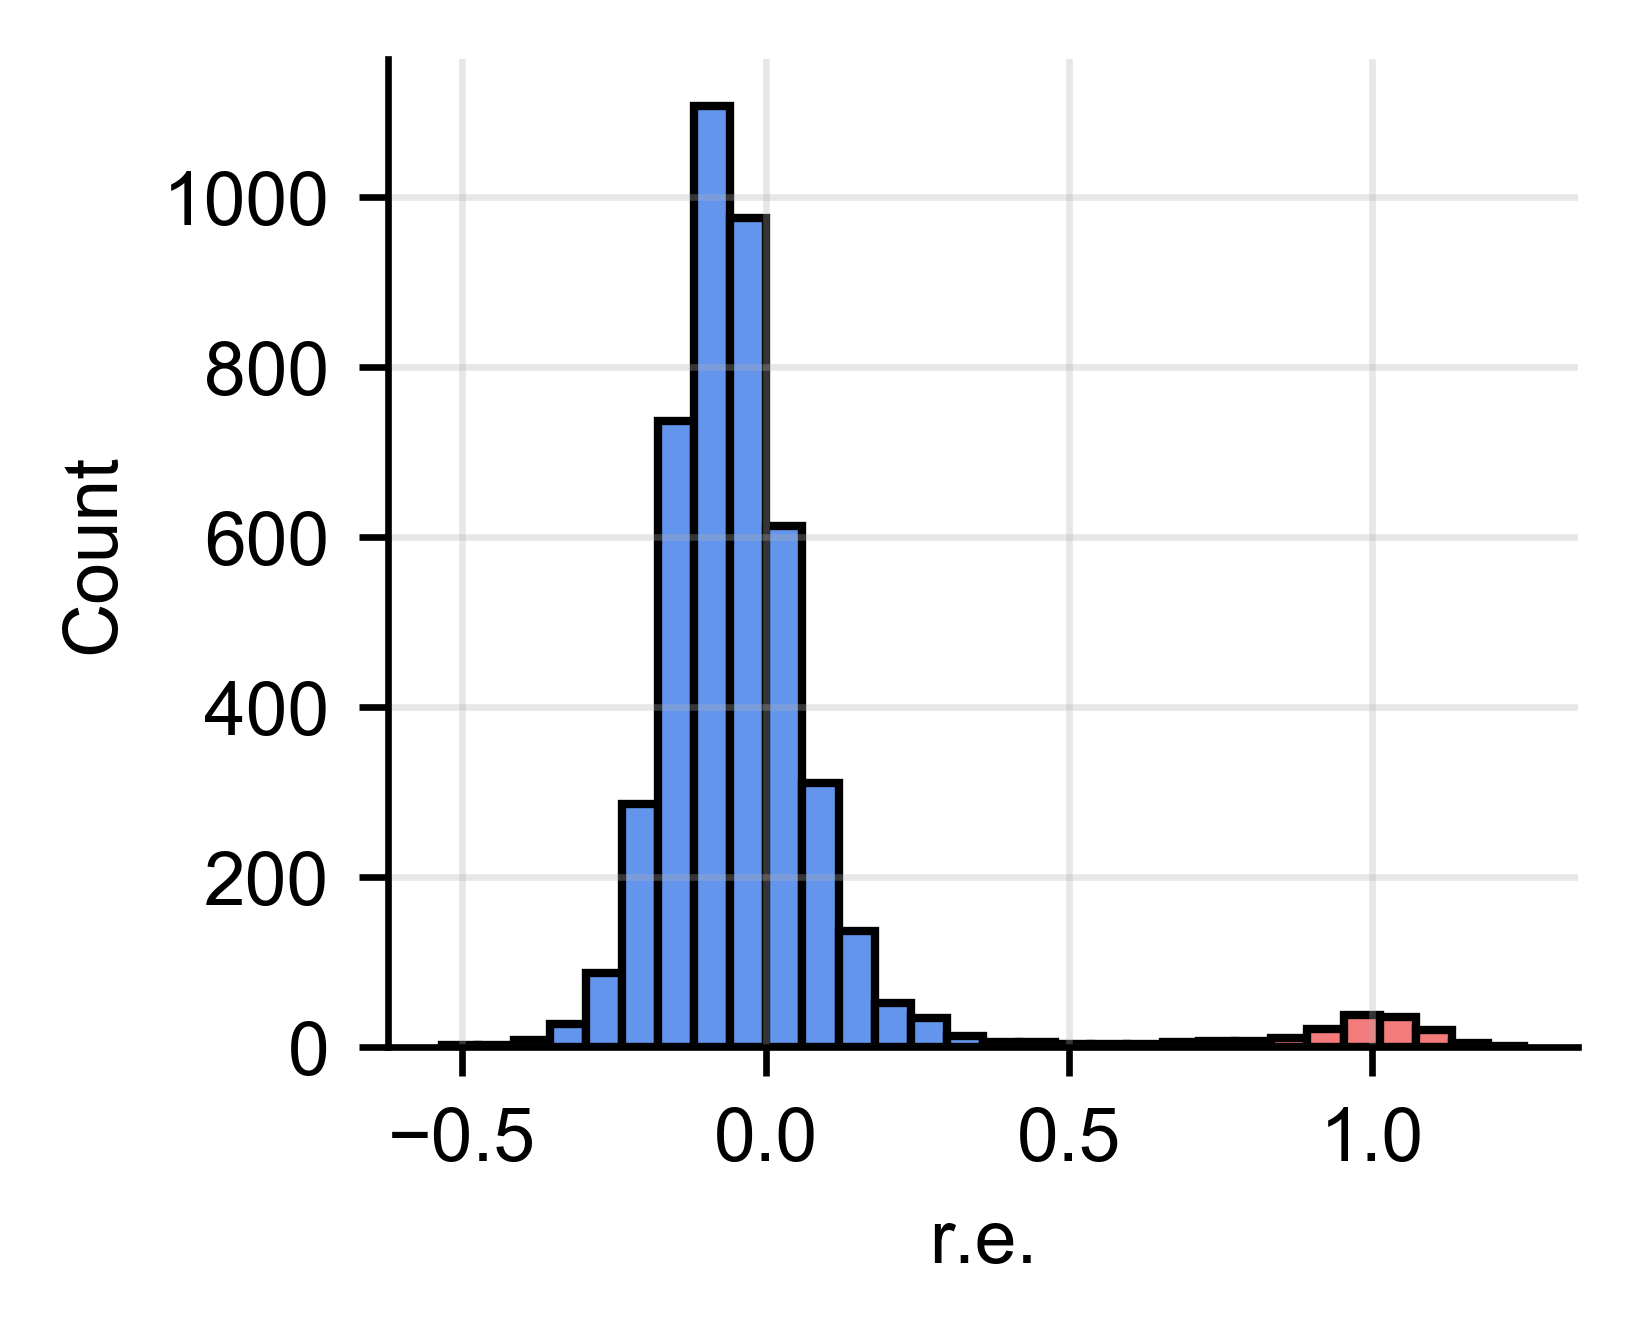

In [4]:
fig, ax = plt.subplots(figsize = [2.8,2.3],dpi=600)
N_hist1, bins, patches = ax.hist(RE_corr,30,color = '#f47b7b', edgecolor='k',linewidth=1)
ax.set_xlabel('r.e.')
ax.set_ylabel('Count')
#ax.set_title('in YPD + 1M KCl')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(alpha=.3)
for i in range(0,18):    
    patches[i].set_facecolor('cornflowerblue')
plt.tight_layout()
plt.show()

In [9]:
resc_func = 0.84158931

In [10]:
VAE_global,VAE_local,mmd_global,mmd_local,bm = \
np.arange(1,3985),np.arange(3985,4881),np.arange(8621,10621),np.arange(10621,11608),np.arange(4881,8621)

VAE_all = np.hstack([VAE_global,VAE_local])
mmd_all = np.hstack([mmd_global,mmd_local])

good_design = [i for i in range(11607) if res[i]>=resc_func]
good_design_mmd = [i for i in mmd_all if i in good_design]
no_good_design_mmd = [i for i in mmd_all if i not in good_design]

In [11]:
pltlist = np.array([RE_corr,res[mmd_global], res[mmd_local], res[bm],res[VAE_global], res[VAE_local]],dtype=object)
good_design_r = np.zeros(len(pltlist.flatten()))
good_design_n = np.zeros(6)
for num,i in enumerate(pltlist.flatten()):
    good_design_n[num] = len([j for j in i if j>=resc_func and j<5]) # number of good seqs in each designed set
    good_design_r[num] = good_design_n[num]/len(i) # ratio of good seqs in each designed set

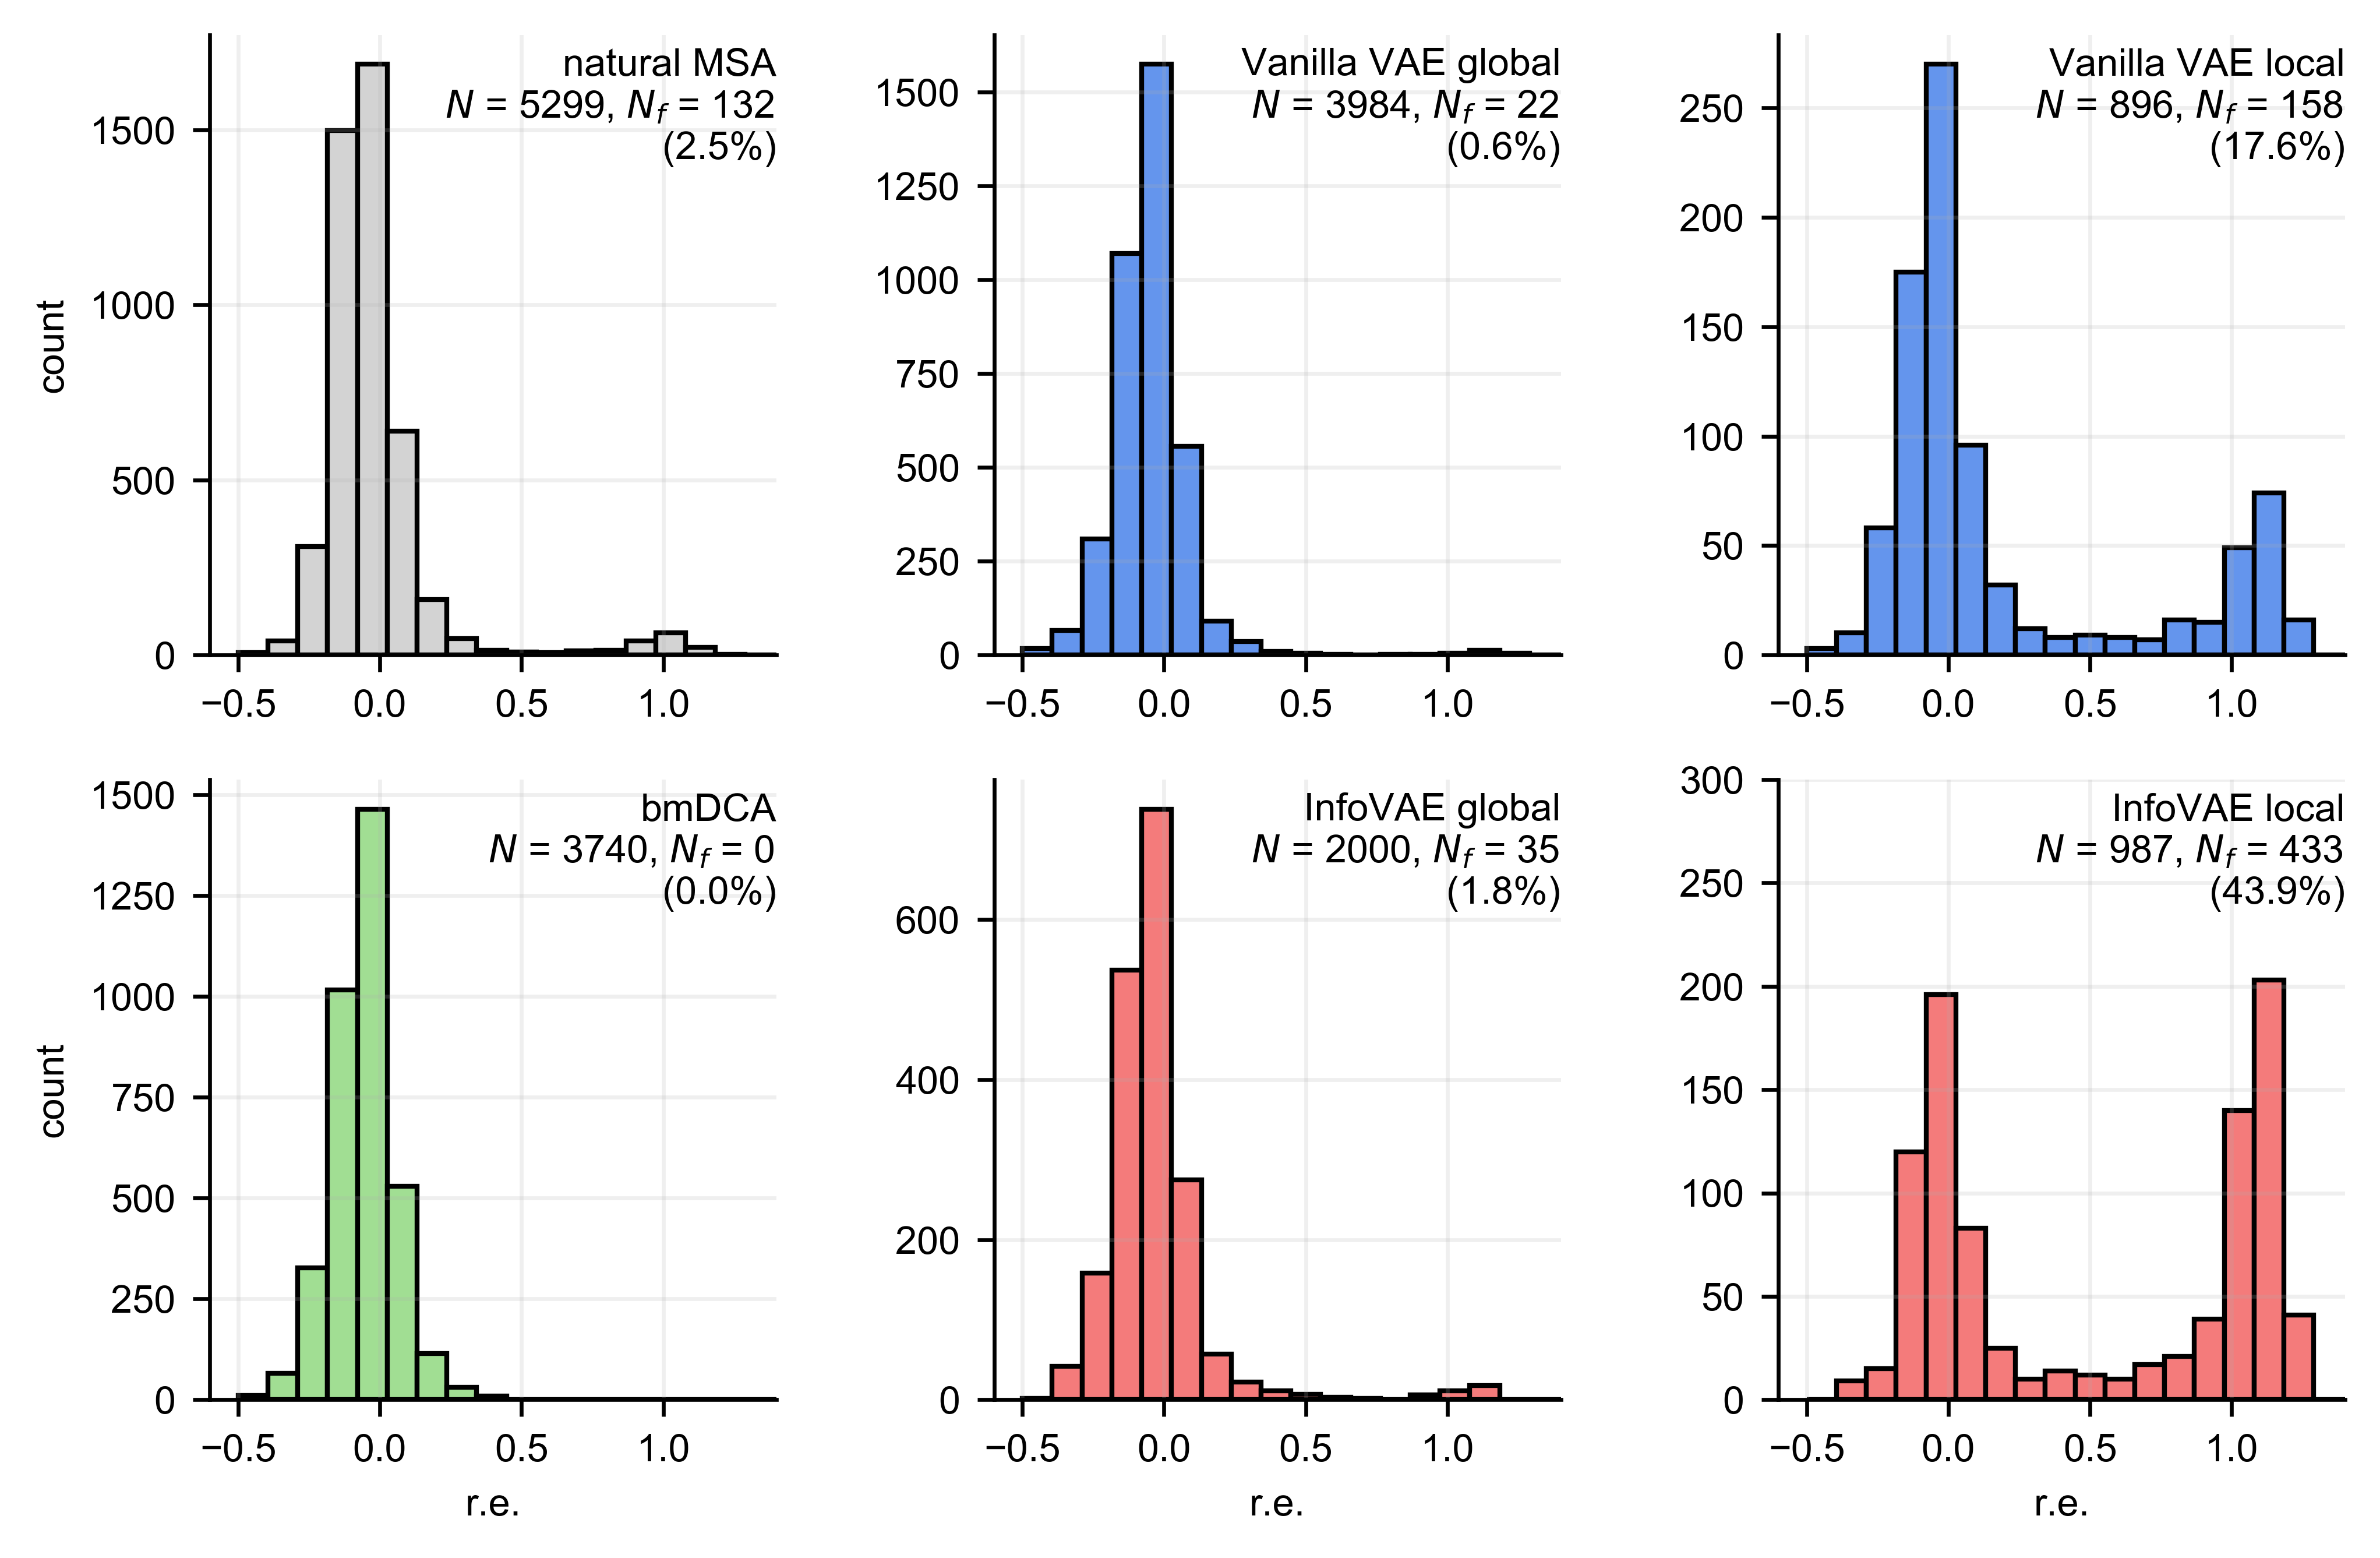

In [13]:
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(2,3,figsize = [6.85,4.5],dpi=600)

pltlist = np.array([RE_corr,res[VAE_global], res[VAE_local], res[bm],res[mmd_global], res[mmd_local]],dtype=object)
text = np.array(['natural MSA','Vanilla VAE global', 'Vanilla VAE local',
                 'bmDCA', 'InfoVAE global', 'InfoVAE local'],dtype=object)
clist = np.array(['lightgrey','cornflowerblue','cornflowerblue','#a1de93','#f47b7b','#f47b7b'],dtype=object)

for num,i in enumerate(pltlist.flatten()):
    good_design_n[num] = len([j for j in i if j>=resc_func and j<5]) # number of good seqs in each designed set
    good_design_r[num] = good_design_n[num]/len(i) # ratio of good seqs in each designed set

pltlist=pltlist.reshape(2,3)
text=text.reshape(2,3)
clist=clist.reshape(2,3)

ax[1,2].set_ylim([0,300]) #mmdVAE

for i in range(3):
    for j in range(2):
        n=np.linspace(-.5,1.5,20)
        ax[j,i].hist(pltlist[j,i],n,color = clist[j,i], edgecolor='k',linewidth=1)
        ax[j,i].text(1.4,ax[j,i].get_ylim()[1]*.8,
                     "%s\n $N$ = %d, $N_f$ = %d \n(%.1f"%(text[j,i], len(pltlist[j,i]), \
                                           good_design_n.reshape(2,3)[j,i], \
                                           100*good_design_r.reshape(2,3)[j,i])+'%)',
                     ha='right')
        ax[j,i].grid(alpha=.2)
        ax[j,i].spines['right'].set_visible(False)
        ax[j,i].spines['top'].set_visible(False)
        ax[j,i].set_xlim([-.6,1.4])
        ax[j,0].set_ylabel('count')
    ax[1,i].set_xlabel('r.e.')

plt.tight_layout(w_pad=2.5)
plt.savefig('Taxonomy_and_convex_hull/figures/re.pdf')
plt.show()

In [9]:
mmd_closest_id = list(design_sheet.loc[mmd_global,'closest_id'])+list(design_sheet.loc[mmd_local,'closest_id'])
mmd_sho1_id = list(design_sheet.loc[mmd_global,'Sho1_id'])+list(design_sheet.loc[mmd_local,'Sho1_id'])
VAE_closest_id = list(design_sheet.loc[VAE_global,'closest_id'])+list(design_sheet.loc[VAE_local,'closest_id'])
VAE_sho1_id = list(design_sheet.loc[VAE_global,'Sho1_id'])+list(design_sheet.loc[VAE_local,'Sho1_id'])

test=pd.DataFrame(data={'id':mmd_sho1_id,'re':res[mmd_all]})
print(59-min(test[test['re']>.5]['id'])*59)

test=pd.DataFrame(data={'id':VAE_closest_id,'re':res[VAE_all]})
print(59-59*min(test[test['re']>.5]['id']))

test=pd.DataFrame(data={'id':mmd_closest_id,'re':res[mmd_all]})
print(59-59*min(test[test['re']>.5]['id']))

test=pd.DataFrame(data={'id':VAE_sho1_id,'re':res[VAE_all]})
print(59-59*min(test[test['re']>.5]['id']))

41.00000000000005
31.00000000000004
25.0
42.0


In [10]:
'''
test=pd.DataFrame(data={'id':mmd_sho1_id,'re':res[mmd_all]})
a=test.id<.2
b=test.re>.5
design_sheet.loc[test[a&b].index[0]]
'''
test=pd.DataFrame(data={'re':res[bm]})
design_sheet.loc[test[test.re>.5].index[0]]

header                                                  bmDCA9_1837
seq               KSPITCFALYAYQAQADDDDEIEQEAGDKIENIEHVDGWTRGKLAR...
count_t0_ex1                                                     11
count_typd_ex1                                                   18
count_t05_ex1                                                    15
count_t1_ex1                                                     14
re_ypd_ex1                                                 0.294138
re_05_ex1                                                 -0.359559
re_1_ex1                                                  -0.779462
count_t0_ex2                                                     13
count_typd_ex2                                                    4
count_t05_ex2                                                    35
count_t1_ex2                                                     36
re_ypd_ex2                                                -0.434655
re_05_ex2                                       

In [ ]:
KSPITCFALYAYQAQADDDDEIEQEAGDKIENIEHVDGWTRGKLARGESGLMPINYRSKSCN

In [11]:
id_list = [[VAE_closest_id,mmd_closest_id,],
           [VAE_sho1_id,mmd_sho1_id]]
re_id_list = [[res[VAE_all], res[mmd_all],],
             [ res[VAE_all], res[mmd_all]]]
label_list = [['Vanilla VAE designed','infoVAE designed',],
              ['Vanilla VAE designed','infoVAE designed']]
clist = [['cornflowerblue','#f47b7b'],
         ['cornflowerblue','#f47b7b']]

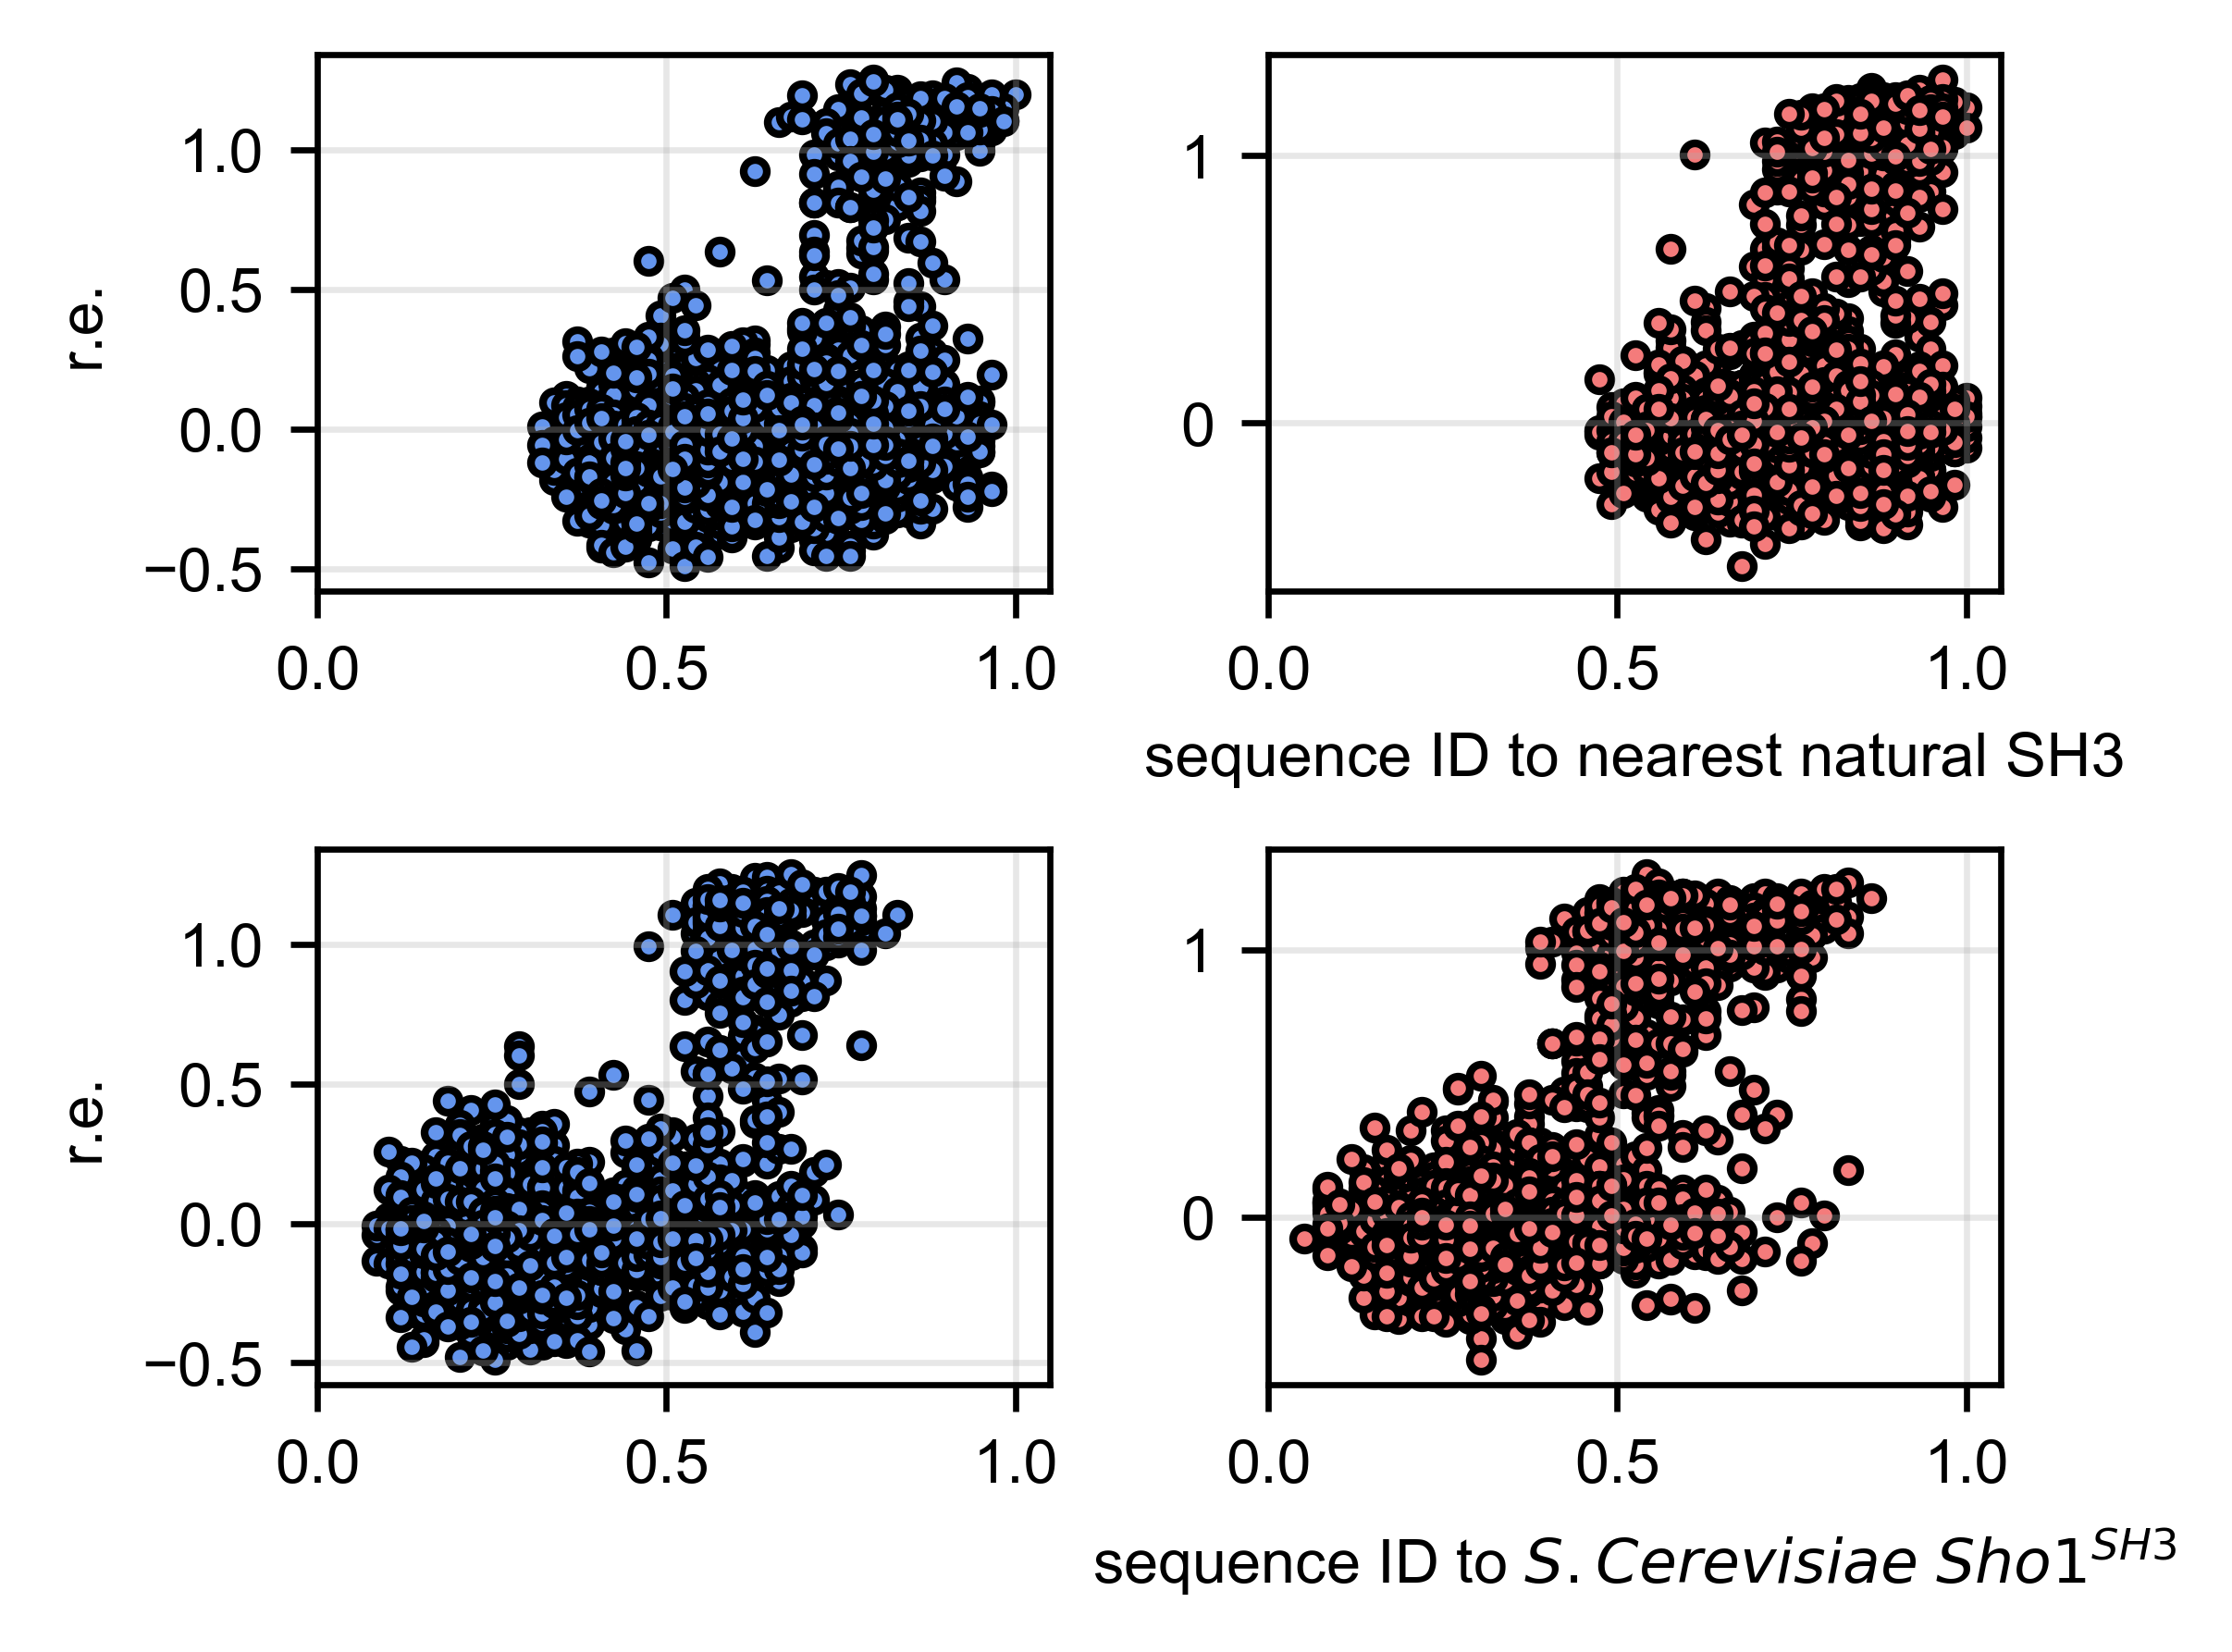

In [12]:
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(2,2,figsize = [4,3],dpi=600)
for i in range(2):
    for j in range(2):
        ax[i,j].grid(alpha=.3)
        ax[i,j].scatter(id_list[i][j],re_id_list[i][j],edgecolor='k',s=9, c = clist[i][j])
        ax[i,j].set_xlim([.0, 1.05])
        ax[0,1].set_xlabel('sequence ID to nearest natural SH3')
        ax[1,1].set_xlabel('sequence ID to $S. Cerevisiae$ $Sho1^{SH3}$')
    ax[i,0].set_ylabel('r.e.')
plt.tight_layout(pad=1)